<a href="https://colab.research.google.com/github/zloelias/hse-project-vae-lstm/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
!pip install sranodec
!pip install skorch
!pip install pytorch-lightning

     |████████████████████████████████| 133kB 6.9MB/s 
     |████████████████████████████████| 808kB 7.7MB/s 
     |████████████████████████████████| 829kB 19.6MB/s 
     |████████████████████████████████| 276kB 39.2MB/s 
     |████████████████████████████████| 645kB 37.1MB/s 
     |████████████████████████████████| 10.6MB 37.5MB/s 
     |████████████████████████████████| 112kB 37.9MB/s 
     |████████████████████████████████| 1.3MB 45.5MB/s 
     |████████████████████████████████| 296kB 36.4MB/s 
     |████████████████████████████████| 143kB 39.9MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=fa0a37e6fa15361269bf58c3c998a032469c8e4825abe1380cd3c6cbffdc9b7b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: future 0.

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sranodec import Silency
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pytorch_lightning as pl


In [4]:
class KPIDataset(Dataset):
    def __init__(self, X, label, window_len=256, sliding_step=1):
        self.start = 0
        self.window_len = window_len
        self.sliding_step = sliding_step
        #self.df = X
        timeseries = ((X.value - X.value.mean()) / X.value.std()).values
        W = self.normality_weights(X.value)
        temp = []
        temp_W = []
        self.label = label.values[self.window_len-1:-1]
        self.y = ((X.value - X.value.mean()) / X.value.std()).values[self.window_len:] 
        for i in range(self.start, len(timeseries) - self.window_len*self.sliding_step, self.sliding_step):
            temp.append(
                torch.unsqueeze(torch.tensor(timeseries[i:i+self.window_len]), 0)
            )
            temp_W.append(
                torch.unsqueeze(torch.tensor(W[i:i+self.window_len]), 0)
            )
        self.features = torch.Tensor(len(temp), self.window_len)
        self.W = torch.Tensor(len(temp_W), self.window_len)
        torch.cat(temp, out=self.features)
        torch.cat(temp_W, out=self.W)
    def normality_weights(self, x):
        window = 1440
        saliency = Silency(window // 8, window // 8, window * 2)
        D = saliency.generate_anomaly_score(x, type='abs')
        W = (1 - 1 / (1 + np.exp(-(D))))*2
        return W

    def __getitem__(self, i):
        return self.features[i].unsqueeze(dim=0), self.W[i].unsqueeze(dim=0), self.label[i], self.y[i]
    
    def __len__(self):
        return len(self.features)



In [5]:
DEBUG = False
window_len = 256

if DEBUG:
    BATCH_SIZE = 32768
else:
    BATCH_SIZE = 2048


In [6]:
 files = [
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/0.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/2.csv',         
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/4.csv',         
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/5.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/6.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/7.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/9.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/10.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/11.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/12.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/13.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/14.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/15.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/16.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/17.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/18.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/21.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/22.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/24.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/25.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/27.csv',
    'https://raw.githubusercontent.com/zloelias/hse-project-vae-lstm/main/data/28.csv'
 ]

#files = [files[i] for i in range(0, len(files), 2)]

if DEBUG:
    files = [files[-2]]

train_datasets = []
val_datasets = []
test_datasets = []

train_dataloaders = []
val_dataloaders = []
test_dataloaders = []

for file in files:
    df = pd.read_csv(file, index_col=0, header=0)
    y = df.label
    X = df.drop('label', axis=1).drop('KPI ID', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
    train_datasets.append(KPIDataset(X_train, y_train, window_len=window_len, sliding_step=1))
    val_datasets.append(KPIDataset(X_val, y_val, window_len=window_len, sliding_step=1))
    test_datasets.append(KPIDataset(X_test, y_test, window_len=window_len, sliding_step=1))

    train_dataloaders.append(DataLoader(train_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))
    val_dataloaders.append(DataLoader(val_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))
    test_dataloaders.append(DataLoader(test_datasets[-1], batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True))



/usr/local/lib/python3.7/dist-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


In [7]:
class CustomDataset(Dataset):
    def __init__(self, datasets):
        self.datasets = datasets

        self.map_indexes = [[] for _ in self.datasets]

        self.min_length = min(len(d) for d in self.datasets)
        self.max_length = max(len(d) for d in self.datasets)

    def __getitem__(self, i):
        return tuple(d[m[i]] for d, m in zip(self.datasets, self.map_indexes))

    def construct_map_index(self):
        def update_indices(original_indexes, target_len, max_len):
            # map max_len to target_len (large to small)

            # return: a list, which maps the range(max_len) to the valid index in the dataset
            
            original_indexes = original_indexes[max_len:] # remove used indices
            fill_num = max_len - len(original_indexes)
            batch = fill_num // target_len

            if fill_num % target_len != 0:
                # to let the fill_num + len(original_indexes) greater than max_len
                batch += 1

            additional_indexes = list(range(target_len)) * batch
            #random.shuffle(additional_indexes)

            original_indexes += additional_indexes

            assert len(original_indexes) >= max_len, "the length of matcing indexes is too small"

            return original_indexes

        self.map_indexes = [update_indices(m, len(d), self.max_length) 
            for m, d in zip(self.map_indexes, self.datasets)]

    def __len__(self):
        # will be called every epoch
        self.construct_map_index()
        return self.max_length

In [8]:
train_dataset = CustomDataset(train_datasets)
val_dataset = CustomDataset(val_datasets)
test_dataset = CustomDataset(test_datasets)
if DEBUG:
    plot_dataset = CustomDataset([test_datasets[0]])
else:
    plot_dataset = CustomDataset([test_datasets[12]])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
plot_dataloader = DataLoader(plot_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [9]:
class VAE(pl.LightningModule):
    def __init__(self, h_dim : int=128, z_dim : int=32, k : float=11.5, beta : float=.01, delay : int=7, use_weights : bool=True):
        super(VAE, self).__init__()
        self.k_ = k
        self.beta_ = beta
        self.delay_ = delay
        self.use_weights_ = use_weights
        self.x_groundtruth = np.array([])
        self.x_recon = np.array([])
        self.w = np.array([])
        self.mae_recon = np.array([])
        self.std = np.array([])
        self.anomaly_groundtruth = np.array([])
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(16, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(32, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv1d(64, 128, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Flatten(start_dim=1)
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (h_dim, 1)),
            nn.ConvTranspose1d(h_dim, 64, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=4),
            nn.LeakyReLU(negative_slope=0.1),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=4),
            nn.Tanhshrink(),
        )
        
    def clear(self):
        self.x_groundtruth = np.array([])
        self.x_recon = np.array([])
        self.mae_recon = np.array([])
        self.std = np.array([])
        self.anomaly_groundtruth = np.array([])
        self.w = np.array([])

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        eps = torch.randn(*mu.size(), device=self.device)
        #print(f'esp {esp.shape}')
        #print(f'srt {std.shape}')
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        #print(f'mu: {mu.shape}')
        #print(f'logvar: {logvar}')
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        #print(f'x {x.shape}')
        #print(f'h {h.shape}')
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z

    def step(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, recon_x, x, mu, logvar, w):
        if self.use_weights_:
            recon_loss = torch.mean(w * (recon_x - x) ** 2, dim=-1)#.mean()#weighted_mse_loss(recon_x, x, w)
            wk = w.mean(dim=-1)
        else:
            mse = nn.MSELoss()
            recon_loss = mse(recon_x, x)
            wk = 1
        #KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)
        loss = torch.mean(recon_loss + self.beta_ * wk * KLD)
        logs = {
            "recon_loss": torch.mean(recon_loss),
            "kl": torch.mean(KLD),
            "loss": torch.mean(loss),
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.log_dict({f'recon_mae_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_epoch=True)
            self.log_dict({f"train_{k}_{self.current_epoch}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def training_epoch_end(self, processed_epoch_output):
        self.eval_mae_std([self.trainer.logged_metrics[k].detach().item() for k in self.trainer.logged_metrics.keys() if k.find('recon_mae_') == 0])

    def validation_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.log('val_loss', loss, on_epoch=True)
            self.log_dict({f"val_{k}_{self.current_epoch}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, mu, logvar, w)
            self.log_dict({f"test_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            self.w = np.concatenate((self.w, w[:,0,-1].detach().cpu().numpy()))
            self.x_groundtruth = np.concatenate((self.x_groundtruth, x[:,0,-1].detach().cpu().numpy()))
            self.anomaly_groundtruth = np.concatenate((self.anomaly_groundtruth, l.detach().cpu().numpy()))
            self.x_recon = np.concatenate((self.x_recon, x_recon[:,0,-1].detach().cpu().numpy()))
            self.mae_recon = np.concatenate((self.mae_recon, torch.abs(x_recon[:,0,-1] - x[:,0,-1]).detach().cpu().numpy()))
            self.std = np.concatenate((self.std, torch.abs(x - x_recon).std(dim=2).squeeze().detach().cpu().numpy()))
        return loss

    def test_epoch_end(self, output):
        self.mae_std_ = np.std(np.abs(model.x_groundtruth - model.x_recon))
        self.detect_anomaly()

    def detect_anomaly(self):
        #self.anomaly_pointwise = np.concatenate(np.zeros(window_len), (self.mae_recon > self.std*self.k_).astype(int))
        #self.anomaly_pointwise = (self.mae_recon > self.std*self.k_).astype(int)
        self.anomaly_pointwise = (self.mae_recon > self.mae_std_*self.k_).astype(int)
        self.adjust_detected_anomaly()
        #self.anomaly_pointwise[0:window_len] = 0

    def adjust_detected_anomaly(self):
        #self.anomaly_adjusted = np.zeros(self.anomaly_pointwise.shape[0])
        self.anomaly_adjusted = np.copy(self.anomaly_pointwise)
        i = 0
        while i < self.anomaly_groundtruth.shape[0]:
            if self.anomaly_groundtruth[i] == 0:
                i += 1
                continue
            else:
                # get anomaly len
                len = 1
                while i+len < self.anomaly_groundtruth.shape[0] and self.anomaly_groundtruth[i+len] == 1:
                    len += 1
                # check detected anomaly in delay window
                if sum(self.anomaly_pointwise[i:i+self.delay_])>0:
                    self.anomaly_adjusted[i:i+len] = 1
                i += len
 
    def eval_mae_std(self, mae_arr):
        self.mae_std_ = np.std(mae_arr)

    def threshold(self):
        return self.k_ * self.mae_std_



In [10]:
class LSTM(pl.LightningModule):

    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTM, self).__init__()
        self.y_pred = np.array([])
        self.y_true = np.array([])
        
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, bias=True)
        
        self.fc1 = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanhshrink()
        #self.fc2 = nn.Linear(64, 1)

    def clear(self):
        self.y_true = np.array([])
        self.y_pred = np.array([])

    def set_pretrained_vae(self, vae):
        self.vae = vae

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=self.device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size, device=self.device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc1(h_out)
        out = self.tanh(out)
        #out = self.fc2(out)        
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, y_pred, y_true):
        mse_loss = nn.MSELoss(reduction='mean')
        eps = 1e-6
        mse = mse_loss(y_pred.float(), y_true.float())
        rmse = ((mse + eps)**0.5).float()
        mae = torch.mean(torch.abs(y_pred - y_true))
        logs = {
            "mse": mse,
            "rmse": rmse,
            "mae": mae
        }
        return mse, rmse, mae, logs

    def training_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, _, _ = self.vae.step(x)
            y_pred = self.forward(x_recon).squeeze()
            loss, rmse, mae, logs = self.loss(y_pred, y_true)
            #self.log_dict({f'recon_mae_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"train_{k}_{self.current_epoch}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, _, _ = self.vae.step(x)
            y_pred = self.forward(x_recon).squeeze()
            loss, rmse, mae, logs = self.loss(y_pred, y_true)
            self.log('val_loss', loss, on_epoch=True)
            self.log_dict({f"val_{k}_{self.current_epoch}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, _, _ = self.vae.step(x)
            y_pred = self.forward(x_recon).squeeze()
            loss, rmse, mae, logs = self.loss(y_pred, y_true)
            self.log_dict({f"test_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            self.y_pred = np.concatenate((self.y_pred, y_pred.detach().cpu().numpy()))
            self.y_true = np.concatenate((self.y_true, y_true.detach().cpu().numpy()))
        return loss



In [11]:
class VAE_LSTM(pl.LightningModule):

    def __init__(self, vae_h_dim=128, vae_z_dim=32, lstm_input_size=256, lstm_hidden_size=128, beta:float = .01, lmbda:float = 1, use_weights=True):
        super(VAE_LSTM, self).__init__()
        self.beta_ = beta
        self.lambda_ = lmbda
        self.use_weights_ = use_weights
        self.vae = VAE(h_dim=vae_h_dim, z_dim=vae_z_dim, beta=self.beta_, use_weights=use_weights)
        self.lstm = LSTM(lstm_input_size, lstm_hidden_size)
        
    def forward(self, x):
          x_recon, mu, logvar = self.vae.step(x)
          y_pred = self.lstm(x_recon).squeeze()
          return y_pred

    def step(self, x):
          x_recon, mu, logvar = self.vae.step(x)
          y_pred = self.lstm(x_recon).squeeze()
          return x_recon, y_pred, mu, logvar

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def loss(self, x_recon, x, y_pred, y_true, mu, logvar, w):
        vae_loss, vae_logs = self.vae.loss(x_recon, x, mu, logvar, w)
        mse, rmse, mae, _ = self.lstm.loss(y_pred, y_true)
        if self.use_weights_:
            wk = w.mean()
        else:
            wk = 1
        loss = vae_loss + self.lambda_ * wk * mse
        logs = {
            "recon_loss": vae_logs['recon_loss'],
            "kl_loss": vae_logs['kl'],
            "vae_loss": vae_loss,
            "mse": mse,
            "rmse": rmse,
            "mae": mae
        }
        return loss, logs

    def training_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, y_pred, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, y_pred, y_true, mu, logvar, w)
            self.log_dict({f'recon_mae_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_epoch=True)
            self.log_dict({f"train_{k}_{self.current_epoch}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def training_epoch_end(self, processed_epoch_output):
        self.vae.eval_mae_std([self.trainer.logged_metrics[k].detach().item() for k in self.trainer.logged_metrics.keys() if k.find('recon_mae_') == 0])

    def validation_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, y_pred, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, y_pred, y_true, mu, logvar, w)
            self.log('val_loss', loss, on_epoch=True)
            #self.log_dict({f'recon_mae_val_{dataset_idx}_{batch_idx}': torch.mean(torch.abs(x - x_recon))}, on_step=True)
            self.log_dict({f"val_{k}_{self.current_epoch}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            self.log_dict({f"val_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        for dataset_idx, b in enumerate(batch):
            x, w, l, y_true = b
            x_recon, y_pred, mu, logvar = self.step(x)
            loss, logs = self.loss(x_recon, x, y_pred, y_true, mu, logvar, w)
            self.log_dict({f"test_{k}": v for k, v in logs.items()}, on_step=False, on_epoch=True)
            self.vae.x_groundtruth = np.concatenate((self.vae.x_groundtruth, x[:,0,-1].detach().cpu().numpy()))
            self.vae.w = np.concatenate((self.vae.w, w[:,0,-1].detach().cpu().numpy()))
            self.vae.anomaly_groundtruth = np.concatenate((self.vae.anomaly_groundtruth, l.detach().cpu().numpy()))
            self.vae.x_recon = np.concatenate((self.vae.x_recon, x_recon[:,0,-1].detach().cpu().numpy()))
            self.vae.mae_recon = np.concatenate((self.vae.mae_recon, torch.abs(x_recon[:,0,-1] - x[:,0,-1]).detach().cpu().numpy()))
            self.vae.std = np.concatenate((self.vae.std, torch.abs(x - x_recon).std(dim=2).squeeze().detach().cpu().numpy()))
            self.lstm.y_pred = np.concatenate((self.lstm.y_pred, y_pred.detach().cpu().numpy()))
            self.lstm.y_true = np.concatenate((self.lstm.y_true, y_true.detach().cpu().numpy()))
        return loss

    def test_epoch_end(self, output):
        #self.vae.test_epoch_end(output)
        self.vae.detect_anomaly()


In [12]:
def plot_training(metrics, keys):
    n_keys = len(keys)
    fig, ax = plt.subplots(ncols=n_keys, figsize=(24,6))
    for i in range(n_keys):
        ax[i].plot([metrics[k] for k in metrics.keys() if k.find(keys[i]) == 0])
        ax[i].set_title(keys[i])
    plt.show()


In [13]:
def plot_model(r_model, prediction=[], ts_start=-1, ts_end=-1, title=''):
    fig, ax = plt.subplots(figsize=(16, 8))

    if ts_start>=0 and  ts_end > 0:
        rng = range(ts_start, ts_end)
    else:
        if not r_model:
            rng = range(0, len(prediction))
        else:
            rng = range(0, len(r_model.x_groundtruth))

    if r_model:
        ts = range(len(r_model.x_groundtruth[rng]))
    else:
        ts = range(len(prediction[rng]))
    if r_model:
        ts_anomaly = np.argwhere(r_model.anomaly_groundtruth[rng] > 0).reshape(-1)
        pointwise_anomaly = np.argwhere(r_model.anomaly_adjusted[rng] > 0).reshape(-1)

        ax.plot(ts, r_model.x_groundtruth[ts], color='green', label='X')
        ax.plot(ts, r_model.x_recon[ts], color='blue', label='Reconstructed X')
        ax.plot(ts_anomaly, [-3]*len(ts_anomaly), 'o', color='red', label='Groundtruth anomaly')
        ax.plot(pointwise_anomaly, [-4]*len(pointwise_anomaly), 'x', color='orange', label='Detected anomaly')

    if len(prediction) > 0:
        ax.plot(ts, prediction[ts], color='yellow', label='Predicted X')

    ax.legend()
    ax.set_title(title)
    ax.grid()
    plt.show()


In [14]:
def print_detector_metrics(anomaly_groundtruth, anomaly_detected, beta, lmbda, model_type):
    print(f'Anomaly detection {model_type}, beta={beta}, lambda={lmbda}')
    print(f'F1-score: {f1_score(anomaly_groundtruth, anomaly_detected)}, \
        Precision: {precision_score(anomaly_groundtruth, anomaly_detected)}, \
        Recall: {recall_score(anomaly_groundtruth, anomaly_detected)}')


In [15]:
def print_predictor_metrics(mse, rmse, mae, beta, lmbda, model_type):
    print(f'Prediction {model_type}, beta={beta}, lambda={lmbda}')
    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')


In [16]:
early_stop_callback = pl.callbacks.EarlyStopping(
   monitor='val_loss',
   min_delta=0.001,
   patience=3,
   verbose=False,
   mode='min'
)

if DEBUG:
    min_epochs, max_epochs, check_val_every_n_epoch = 3, 20, 5
    gpus = 1
else:
    min_epochs, max_epochs, check_val_every_n_epoch = 20, 200, 5
    gpus = 1


pad_trainer = pl.Trainer(
    gpus=gpus, 
    callbacks=[early_stop_callback], 
    check_val_every_n_epoch=check_val_every_n_epoch, 
    min_epochs=min_epochs, 
    max_epochs=max_epochs,
    auto_scale_batch_size='power',
    gradient_clip_val=0.5
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [21]:
metrics_detection = []
metrics_prediction = []

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


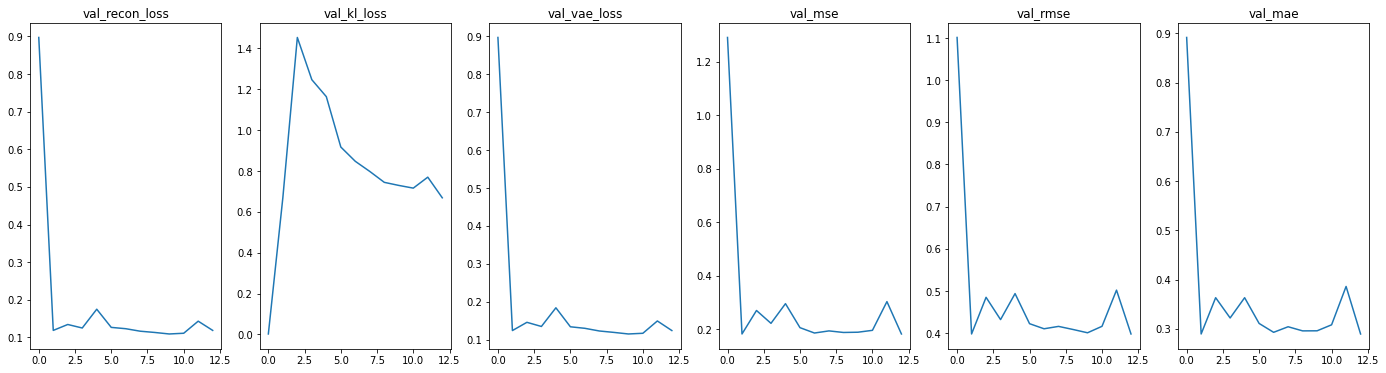

In [ ]:
# PAD

betas = [.01]#, .1, 1, 10]
lmbda = 1#10
for beta in betas:
    pad_trainer = pl.Trainer(
        gpus=gpus, 
        callbacks=[early_stop_callback], 
        check_val_every_n_epoch=check_val_every_n_epoch, 
        min_epochs=min_epochs, 
        max_epochs=max_epochs,
        auto_scale_batch_size='power',
        gradient_clip_val=0.8
    )
    model = VAE_LSTM(beta=beta, lmbda=lmbda)
    pad_trainer.fit(model, train_dataloader, val_dataloader)
    if not DEBUG:
        with open(f'/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD-{beta}-{lmbda}.pcl', 'wb') as f:
            pickle.dump(model, f)

    plot_training(model.trainer.logged_metrics, ['val_recon_loss', 'val_kl_loss', 'val_vae_loss', 'val_mse', 'val_rmse', 'val_mae'])


In [ ]:
beta, lmbda =.01, 1
#dataset = CustomDataset([test_datasets[7]])
#dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [ ]:
model.vae.clear()
model.lstm.clear()
model.vae.w = np.array([])
pad_trainer.test(model, test_dataloaders=train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 0.6819008588790894,
 'test_mae': 0.17584189772605896,
 'test_mse': 0.08262144029140472,
 'test_recon_loss': 0.03224378079175949,
 'test_rmse': 0.24881546199321747,
 'test_vae_loss': 0.03727027401328087}
--------------------------------------------------------------------------------


[{'test_kl_loss': 0.6819008588790894,
  'test_mae': 0.17584189772605896,
  'test_mse': 0.08262144029140472,
  'test_recon_loss': 0.03224378079175949,
  'test_rmse': 0.24881546199321747,
  'test_vae_loss': 0.03727027401328087}]

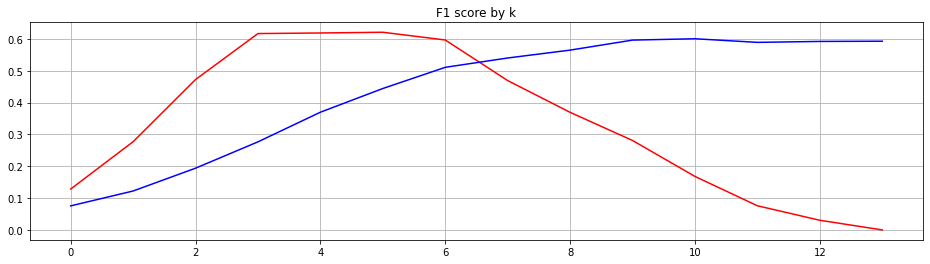

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))
f1_slide = []
f1 = []
f1_slide_w = []
f1_w = []
for k in range(2,16):
    model.vae.anomaly_pointwise = (model.vae.mae_recon > model.vae.std*k).astype(int)
    model.vae.adjust_detected_anomaly()
    f1_slide.append(f1_score(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted))

    model.vae.anomaly_pointwise = (model.vae.mae_recon > model.vae.mae_std_*k).astype(int)
    model.vae.adjust_detected_anomaly()
    f1.append(f1_score(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted))

ax.plot(f1_slide, color='red')
ax.plot(f1, color='blue')

ax.set_title('F1 score by k')
ax.grid()

plt.show()



In [ ]:
model.vae.clear()
model.lstm.clear()
model.vae.w = np.array([])
pad_trainer.test(model, test_dataloaders=test_dataloader)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 0.6793092489242554,
 'test_mae': 0.1726255863904953,
 'test_mse': 0.1036762222647667,
 'test_recon_loss': 0.03477151691913605,
 'test_rmse': 0.259788453578949,
 'test_vae_loss': 0.039845388382673264}
--------------------------------------------------------------------------------


[{'test_kl_loss': 0.6793092489242554,
  'test_mae': 0.1726255863904953,
  'test_mse': 0.1036762222647667,
  'test_recon_loss': 0.03477151691913605,
  'test_rmse': 0.259788453578949,
  'test_vae_loss': 0.039845388382673264}]

In [ ]:
model.vae.k_ = 11.5 #16 #26.4 #3.8
model.vae.detect_anomaly()
#model.vae.anomaly_pointwise = (model.vae.mae_recon > model.vae.mae_std_ * model.vae.k_ ).astype(int)
#model.vae.adjust_detected_anomaly()

mse = pad_trainer.logged_metrics['test_mse'].detach().item()
rmse = pad_trainer.logged_metrics['test_rmse'].detach().item()
mae = pad_trainer.logged_metrics['test_mae'].detach().item()
metrics_prediction.append([mse, rmse, mae])

p, r, f, _ = precision_recall_fscore_support(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, average='binary', zero_division=0)
metrics_detection.append([f, p, r])

print_predictor_metrics(mse, rmse, mae, beta, lmbda, 'PAD')
print_detector_metrics(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, beta, lmbda, 'PAD')
#plot_model(model.vae, prediction=model.lstm.y_pred, ts_start=130000, ts_end=137500, title='PAD')

Prediction PAD, beta=0.01, lambda=1
MSE: 0.1036762222647667, RMSE: 0.259788453578949, MAE: 0.1726255863904953
Anomaly detection PAD, beta=0.01, lambda=1
F1-score: 0.6525441730230761,         Precision: 0.7222364708899718,         Recall: 0.5951181712514529


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 0.6682840585708618,
 'test_mae': 0.3071255683898926,
 'test_mse': 0.18777164816856384,
 'test_recon_loss': 0.09848152101039886,
 'test_rmse': 0.4226979613304138,
 'test_vae_loss': 0.10335902869701385}
--------------------------------------------------------------------------------


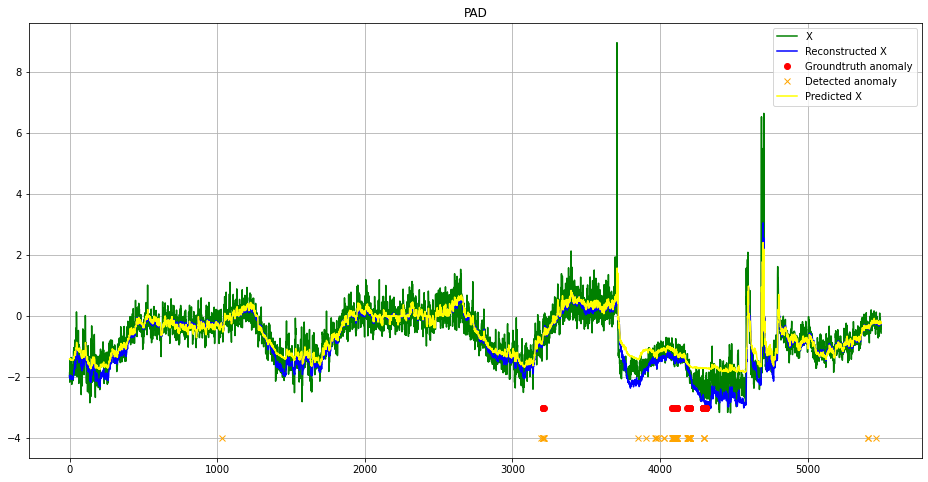

In [ ]:
model.vae.clear()
model.lstm.clear()
pad_trainer.test(model, test_dataloaders=plot_dataloader)
plot_model(model.vae, prediction=model.lstm.y_pred, ts_start=500, ts_end=6000, title='PAD')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


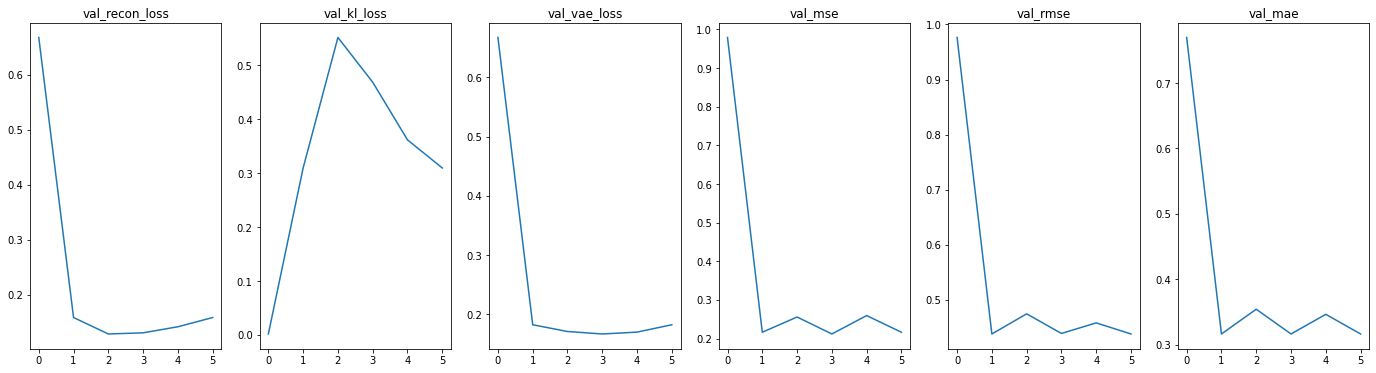

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 0.32061657309532166,
 'test_mae': 0.1912490427494049,
 'test_mse': 0.11585268378257751,
 'test_recon_loss': 0.047756001353263855,
 'test_rmse': 0.2769756615161896,
 'test_vae_loss': 0.07169162482023239}
--------------------------------------------------------------------------------
Prediction PAD, beta=0.1, lambda=1
MSE: 0.11585268378257751, RMSE: 0.2769756615161896, MAE: 0.1912490427494049
Anomaly detection PAD, beta=0.1, lambda=1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


F1-score: 0.5788171942018095,         Precision: 0.5257201353541673,         Recall: 0.6438446804805851



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 0.31639960408210754,
 'test_mae': 0.3161054849624634,
 'test_mse': 0.19632910192012787,
 'test_recon_loss': 0.11686097085475922,
 'test_rmse': 0.43268224596977234,
 'test_vae_loss': 0.13994194567203522}
--------------------------------------------------------------------------------


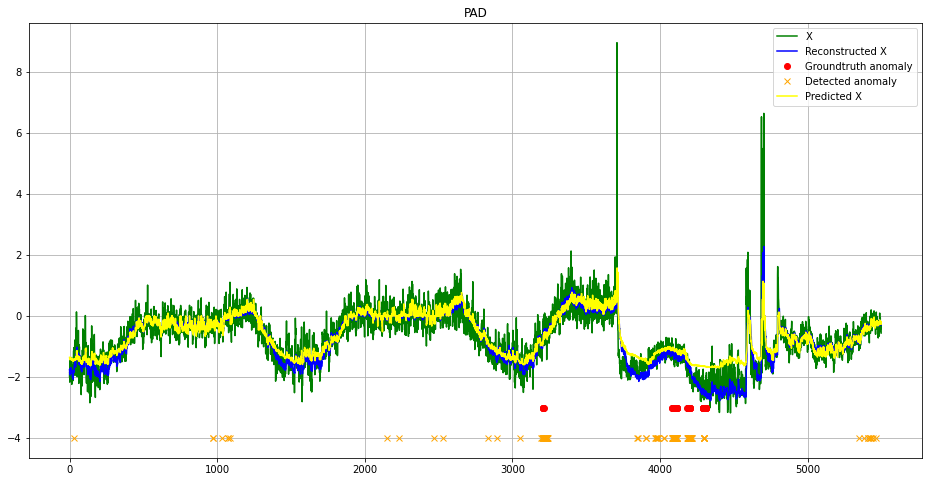

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


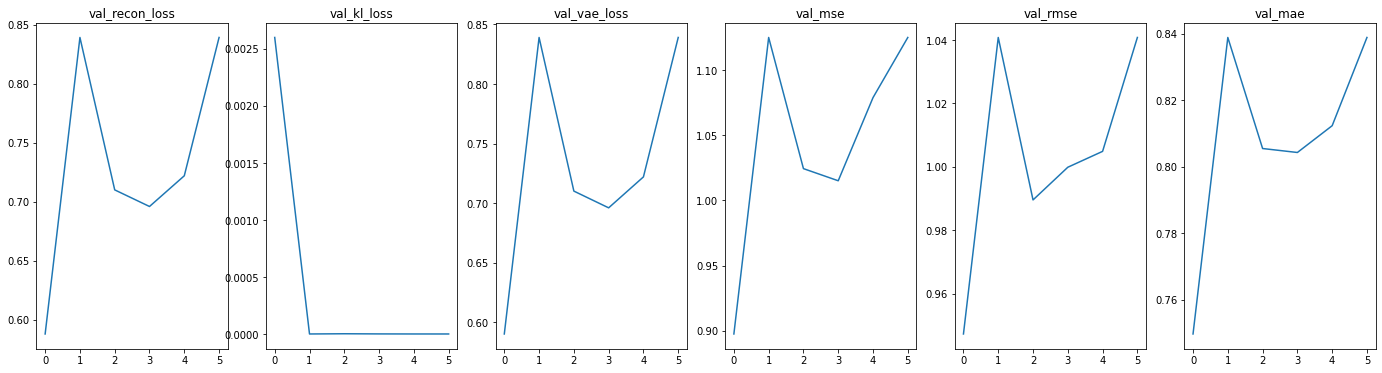

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 4.7212273557306617e-07,
 'test_mae': 0.7889804840087891,
 'test_mse': 0.983773946762085,
 'test_recon_loss': 0.6601724624633789,
 'test_rmse': 0.9597521424293518,
 'test_vae_loss': 0.6601728200912476}
--------------------------------------------------------------------------------
Prediction PAD, beta=1, lambda=1
MSE: 0.983773946762085, RMSE: 0.9597521424293518, MAE: 0.7889804840087891
Anomaly detection PAD, beta=1, lambda=1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


F1-score: 0.3968736797634137,         Precision: 0.5388939880679211,         Recall: 0.31409656279256387



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 7.572634785901755e-07,
 'test_mae': 0.800467312335968,
 'test_mse': 0.9995284676551819,
 'test_recon_loss': 0.6412700414657593,
 'test_rmse': 0.9754502177238464,
 'test_vae_loss': 0.6412705183029175}
--------------------------------------------------------------------------------


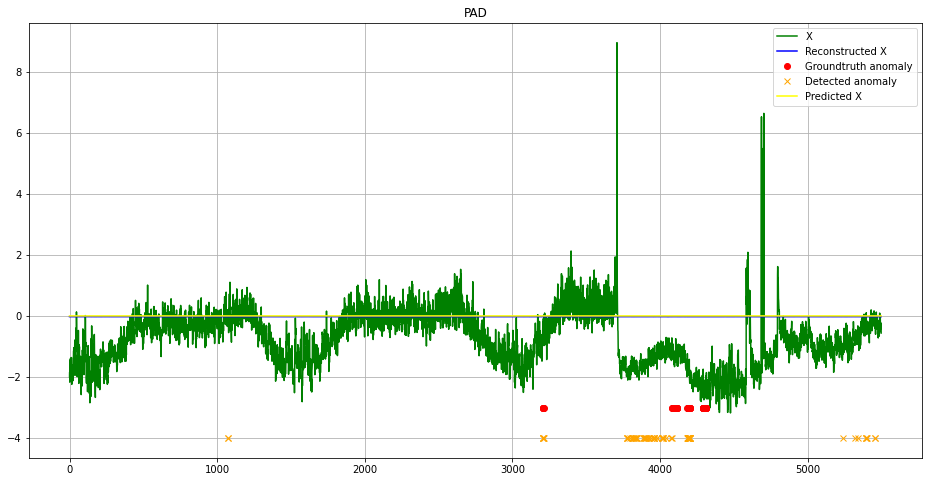

In [ ]:
# PAD

betas = [.1, 1]#, 10]
lmbda = 1
for beta in betas:
    pad_trainer = pl.Trainer(
        gpus=gpus, 
        callbacks=[early_stop_callback], 
        check_val_every_n_epoch=check_val_every_n_epoch, 
        min_epochs=min_epochs, 
        max_epochs=max_epochs,
        auto_scale_batch_size='power',
        gradient_clip_val=0.8
    )
    model = VAE_LSTM(beta=beta, lmbda=lmbda)
    pad_trainer.fit(model, train_dataloader, val_dataloader)
    plot_training(model.trainer.logged_metrics, ['val_recon_loss', 'val_kl_loss', 'val_vae_loss', 'val_mse', 'val_rmse', 'val_mae'])

    model.vae.clear()
    model.lstm.clear()
    pad_trainer.test(model, test_dataloaders=test_dataloader)

    model.vae.k_ = 8.4
    model.vae.detect_anomaly()

    if not DEBUG:
        with open(f'/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD-{beta}-{lmbda}.pcl', 'wb') as f:
            pickle.dump(model, f)

    mse = pad_trainer.logged_metrics['test_mse'].detach().item()
    rmse = pad_trainer.logged_metrics['test_rmse'].detach().item()
    mae = pad_trainer.logged_metrics['test_mae'].detach().item()
    metrics_prediction.append([mse, rmse, mae])

    p, r, f, _ = precision_recall_fscore_support(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, average='binary')
    metrics_detection.append([f, p, r])

    print_predictor_metrics(mse, rmse, mae, beta, lmbda, 'PAD')
    print_detector_metrics(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, beta, lmbda, 'PAD')

    model.vae.clear()
    model.lstm.clear()
    pad_trainer.test(model, test_dataloaders=plot_dataloader)
    plot_model(model.vae, prediction=model.lstm.y_pred, ts_start=500, ts_end=6000, title='PAD')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


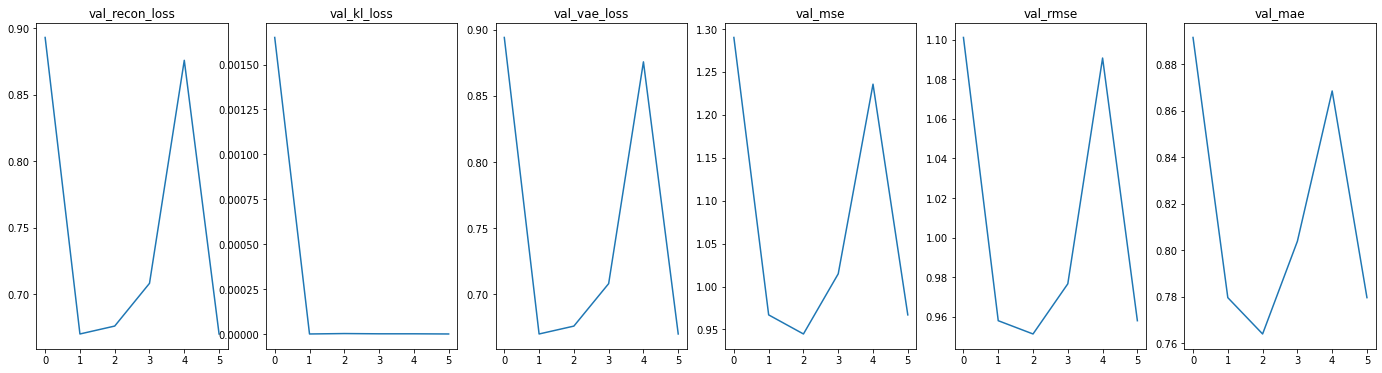

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 3.961115169204277e-07,
 'test_mae': 0.7873499393463135,
 'test_mse': 0.9785434603691101,
 'test_recon_loss': 0.6502655744552612,
 'test_rmse': 0.9620151519775391,
 'test_vae_loss': 0.6502659320831299}
--------------------------------------------------------------------------------
Prediction PAD, beta=1, lambda=1
MSE: 0.9785434603691101, RMSE: 0.9620151519775391, MAE: 0.7873499393463135
Anomaly detection PAD, beta=1, lambda=1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


F1-score: 0.45394379950092223,         Precision: 0.591160845484345,         Recall: 0.3684266140678384



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 6.373456926667131e-07,
 'test_mae': 0.800467312335968,
 'test_mse': 0.9995285272598267,
 'test_recon_loss': 0.641281008720398,
 'test_rmse': 0.9754502177238464,
 'test_vae_loss': 0.6412814259529114}
--------------------------------------------------------------------------------


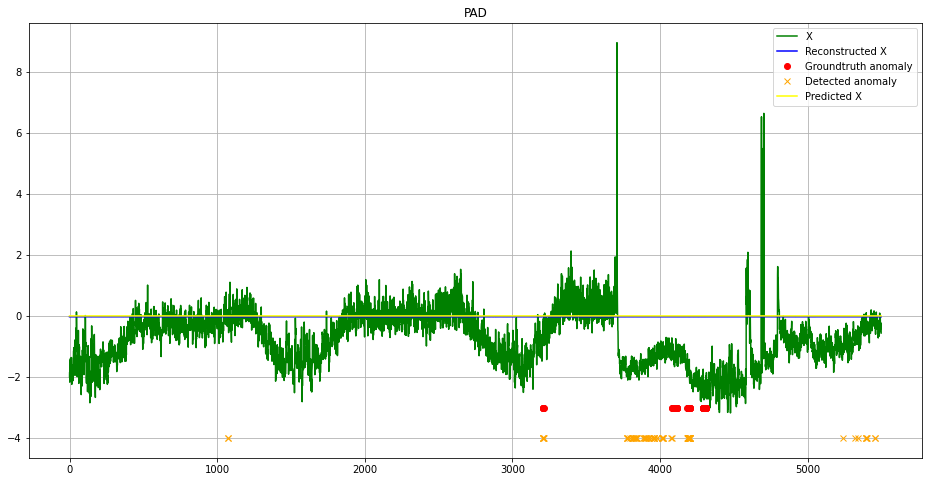

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


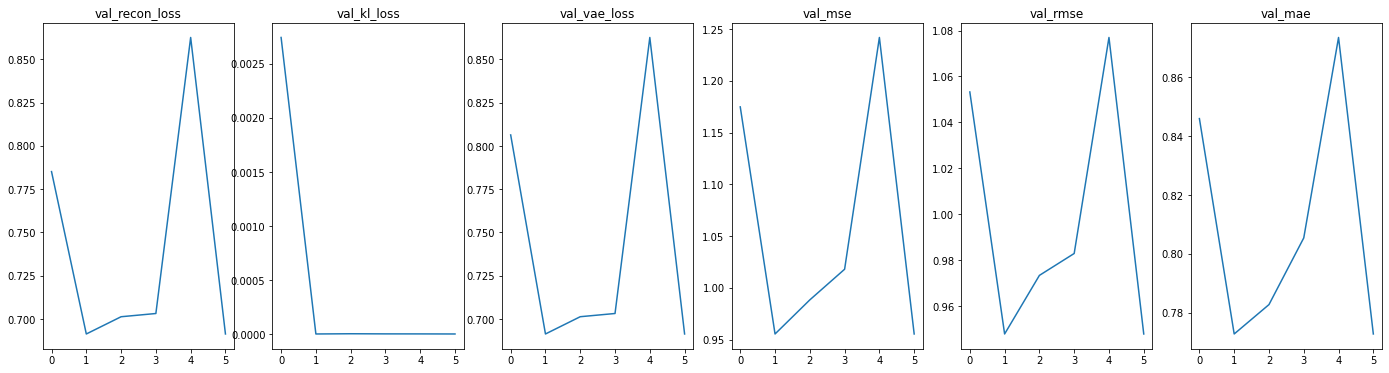

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 5.368300435293349e-07,
 'test_mae': 0.7846362590789795,
 'test_mse': 0.9816491007804871,
 'test_recon_loss': 0.6558570861816406,
 'test_rmse': 0.960553765296936,
 'test_vae_loss': 0.6558611392974854}
--------------------------------------------------------------------------------
Prediction PAD, beta=10, lambda=1
MSE: 0.9816491007804871, RMSE: 0.960553765296936, MAE: 0.7846362590789795
Anomaly detection PAD, beta=10, lambda=1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


F1-score: 0.4207344915309517,         Precision: 0.5600254688585321,         Recall: 0.3369319171164896



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 8.25883603283728e-07,
 'test_mae': 0.8004672527313232,
 'test_mse': 0.9995285272598267,
 'test_recon_loss': 0.6412314772605896,
 'test_rmse': 0.9754502177238464,
 'test_vae_loss': 0.6412374377250671}
--------------------------------------------------------------------------------


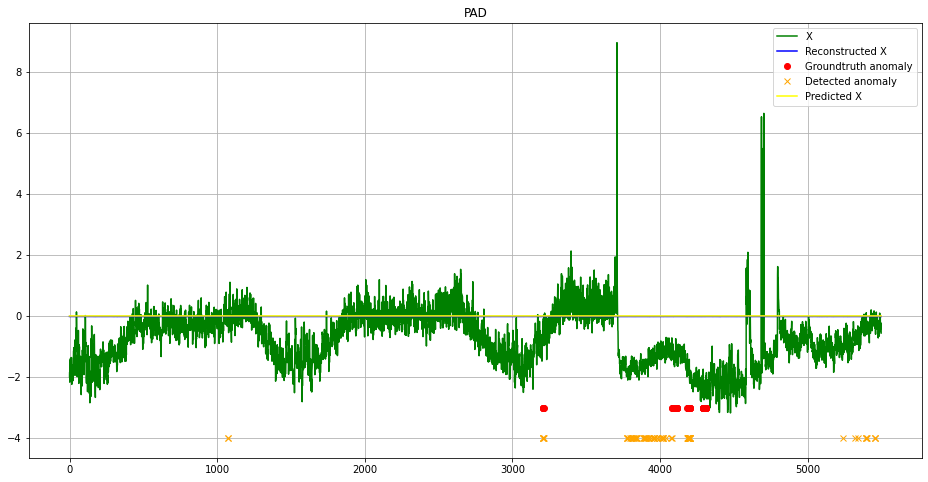

In [22]:
# PAD

betas = [1, 10]
lmbda = 1
for beta in betas:
    pad_trainer = pl.Trainer(
        gpus=gpus, 
        callbacks=[early_stop_callback], 
        check_val_every_n_epoch=check_val_every_n_epoch, 
        min_epochs=min_epochs, 
        max_epochs=max_epochs,
        auto_scale_batch_size='power',
        gradient_clip_val=0.8
    )
    model = VAE_LSTM(beta=beta, lmbda=lmbda)
    pad_trainer.fit(model, train_dataloader, val_dataloader)
    plot_training(model.trainer.logged_metrics, ['val_recon_loss', 'val_kl_loss', 'val_vae_loss', 'val_mse', 'val_rmse', 'val_mae'])

    model.vae.clear()
    model.lstm.clear()
    pad_trainer.test(model, test_dataloaders=test_dataloader)

    model.vae.k_ = 8.4
    model.vae.detect_anomaly()

    if not DEBUG:
        with open(f'/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD-{beta}-{lmbda}.pcl', 'wb') as f:
            pickle.dump(model, f)

    mse = pad_trainer.logged_metrics['test_mse'].detach().item()
    rmse = pad_trainer.logged_metrics['test_rmse'].detach().item()
    mae = pad_trainer.logged_metrics['test_mae'].detach().item()
    metrics_prediction.append([mse, rmse, mae])

    p, r, f, _ = precision_recall_fscore_support(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, average='binary')
    metrics_detection.append([f, p, r])

    print_predictor_metrics(mse, rmse, mae, beta, lmbda, 'PAD')
    print_detector_metrics(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, beta, lmbda, 'PAD')

    model.vae.clear()
    model.lstm.clear()
    pad_trainer.test(model, test_dataloaders=plot_dataloader)
    plot_model(model.vae, prediction=model.lstm.y_pred, ts_start=500, ts_end=6000, title='PAD')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | vae  | VAE  | 99.0 K
1 | lstm | LSTM | 197 K 
------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


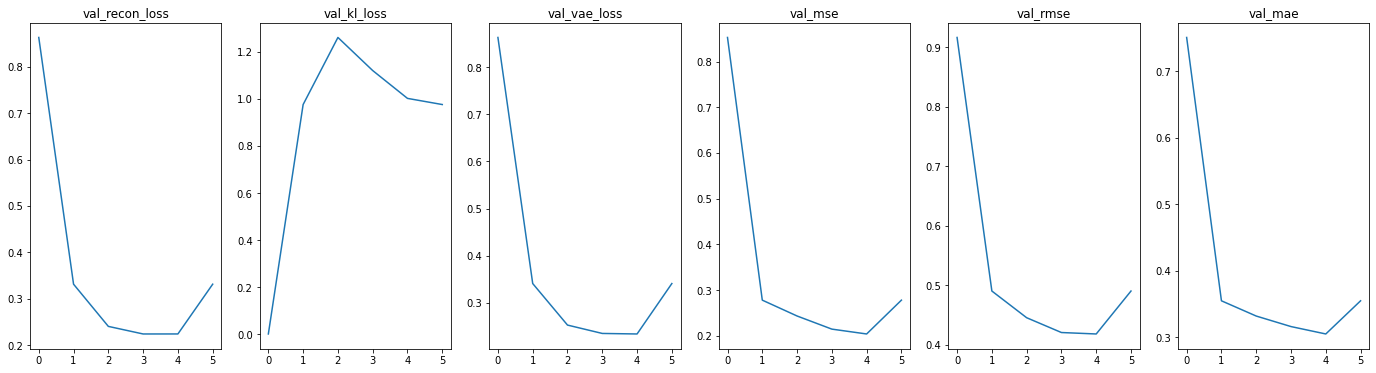

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 0.9627141952514648,
 'test_mae': 0.19734911620616913,
 'test_mse': 0.16234642267227173,
 'test_recon_loss': 0.17745253443717957,
 'test_rmse': 0.3179300129413605,
 'test_vae_loss': 0.18707966804504395}
--------------------------------------------------------------------------------
Prediction PAD, beta=0.01, lambda=1
MSE: 0.16234642267227173, RMSE: 0.3179300129413605, MAE: 0.19734911620616913
Anomaly detection PAD-, beta=0.01, lambda=1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


F1-score: 0.5813994374120955,         Precision: 0.5138683862947712,         Recall: 0.6693654488412104



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl_loss': 0.9186240434646606,
 'test_mae': 0.3250887095928192,
 'test_mse': 0.2111583948135376,
 'test_recon_loss': 0.24205435812473297,
 'test_rmse': 0.44736969470977783,
 'test_vae_loss': 0.2512405812740326}
--------------------------------------------------------------------------------


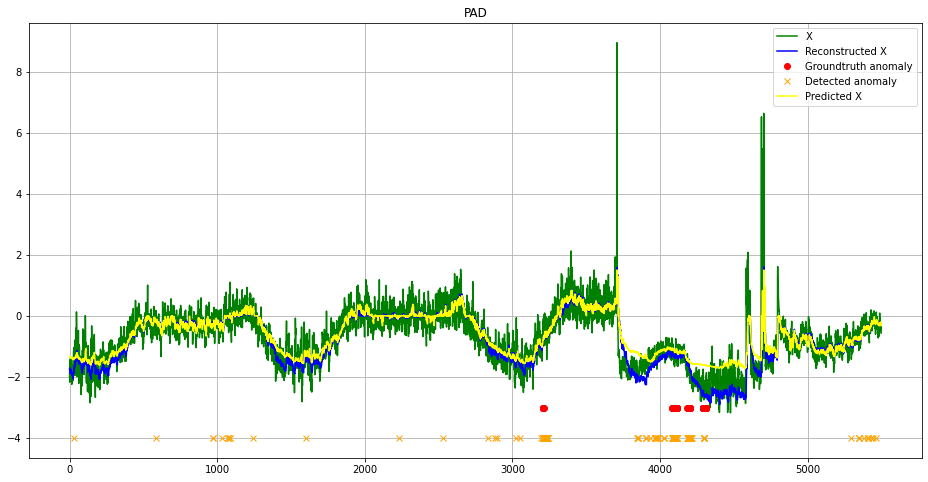

In [ ]:
# PAD-no-weights

betas = [.01] #, 1, 10]
lmbda = 1
for beta in betas:
    pad_trainer = pl.Trainer(
        gpus=gpus, 
        callbacks=[early_stop_callback], 
        check_val_every_n_epoch=check_val_every_n_epoch, 
        min_epochs=min_epochs, 
        max_epochs=max_epochs,
        auto_scale_batch_size='power',
        gradient_clip_val=0.8
    )
    model = VAE_LSTM(beta=beta, lmbda=lmbda, use_weights=False)
    pad_trainer.fit(model, train_dataloader, val_dataloader)
    plot_training(model.trainer.logged_metrics, ['val_recon_loss', 'val_kl_loss', 'val_vae_loss', 'val_mse', 'val_rmse', 'val_mae'])

    model.vae.clear()
    model.lstm.clear()
    pad_trainer.test(model, test_dataloaders=test_dataloader)

    model.vae.k_ = 8.4
    model.vae.detect_anomaly()

    if not DEBUG:
        with open(f'/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/PAD-nw-{beta}-{lmbda}.pcl', 'wb') as f:
            pickle.dump(model, f)

    mse = pad_trainer.logged_metrics['test_mse'].detach().item()
    rmse = pad_trainer.logged_metrics['test_rmse'].detach().item()
    mae = pad_trainer.logged_metrics['test_mae'].detach().item()
    metrics_prediction.append([mse, rmse, mae])

    p, r, f, _ = precision_recall_fscore_support(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, average='binary')
    metrics_detection.append([f, p, r])

    print_predictor_metrics(mse, rmse, mae, beta, lmbda, 'PAD')
    print_detector_metrics(model.vae.anomaly_groundtruth, model.vae.anomaly_adjusted, beta, lmbda, 'PAD-')

    model.vae.clear()
    model.lstm.clear()
    pad_trainer.test(model, test_dataloaders=plot_dataloader)
    plot_model(model.vae, prediction=model.lstm.y_pred, ts_start=500, ts_end=6000, title='PAD')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 43.3 K
1 | fc1     | Linear     | 4.1 K 
2 | fc2     | Linear     | 4.1 K 
3 | fc3     | Linear     | 4.2 K 
4 | decoder | Sequential | 43.2 K
---------------------------------------
99.0 K    Trainable params
0         Non-trainable params
99.0 K    Total params
0.396     Total estimated model params size (MB)


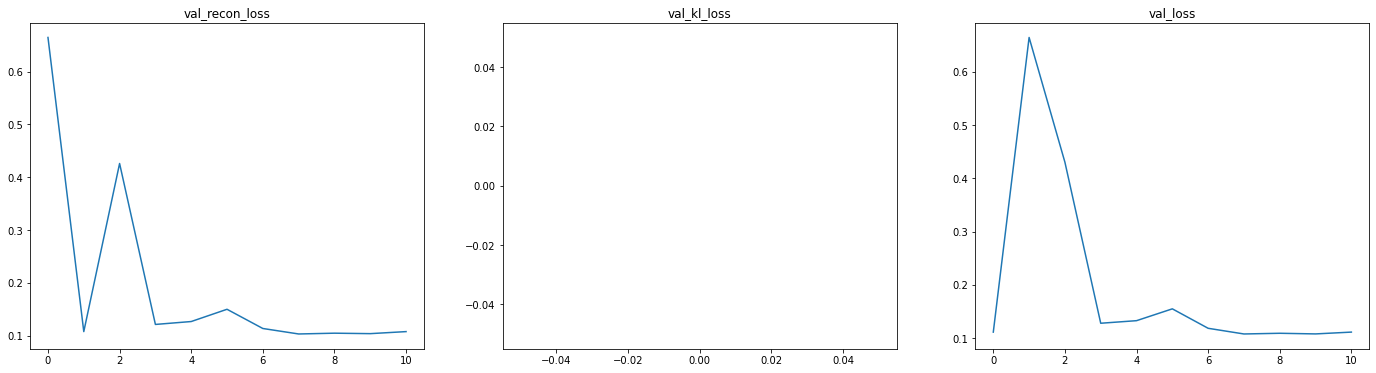

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl': 0.4960792660713196,
 'test_kl_loss': 8.25883603283728e-07,
 'test_loss': 0.03924493119120598,
 'test_mae': 0.8004672527313232,
 'test_mse': 0.9995285272598267,
 'test_recon_loss': 0.035541243851184845,
 'test_rmse': 0.9754502177238464,
 'test_vae_loss': 0.6412374377250671}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl': 0.4965367019176483,
 'test_kl_loss': 8.25883603283728e-07,
 'test_loss': 0.0367443785071373,
 'test_mae': 0.8004672527313232,
 'test_mse': 0.9995285272598267,
 'test_recon_loss': 0.03303920477628708,
 'test_rmse': 0.9754502177238464,
 'test_vae_loss': 0.6412374377250671}
--------------------------------------------------------------------------------
Anomaly detection AD, beta=0.01, lambda=1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


F1-score: 0.22402384500745154,         Precision: 0.9618633222421296,         Recall: 0.12677529264919205



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_kl': 0.49378862977027893,
 'test_kl_loss': 8.25883603283728e-07,
 'test_loss': 0.09705669432878494,
 'test_mae': 0.8004672527313232,
 'test_mse': 0.9995285272598267,
 'test_recon_loss': 0.09345415234565735,
 'test_rmse': 0.9754502177238464,
 'test_vae_loss': 0.6412374377250671}
--------------------------------------------------------------------------------


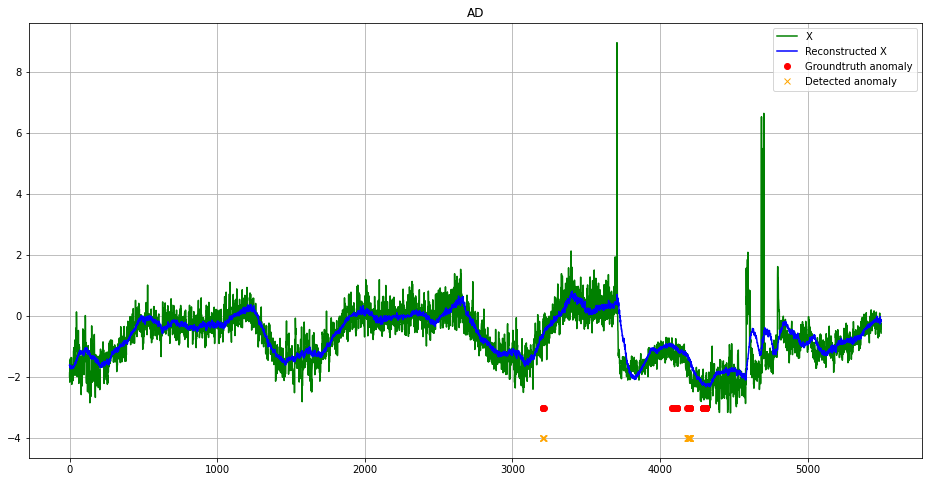

In [23]:
beta = 0.01
trainer = pl.Trainer(
    gpus=gpus, 
    callbacks=[early_stop_callback], 
    check_val_every_n_epoch=check_val_every_n_epoch, 
    min_epochs=min_epochs, 
    max_epochs=max_epochs, 
    auto_scale_batch_size='power',
    gradient_clip_val=0.8
)

model = VAE(beta=beta)
trainer.fit(model, train_dataloader, val_dataloader)

if not DEBUG:
    with open(f'/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/AD.pcl', 'wb') as f:
        pickle.dump(model, f)


plot_training(model.trainer.logged_metrics, ['val_recon_loss', 'val_kl_loss', 'val_loss'])

pad_trainer.test(model, test_dataloaders=test_dataloader)

model.clear()
pad_trainer.test(model, test_dataloaders=test_dataloader)

model.detect_anomaly()

p, r, f, _ = precision_recall_fscore_support(model.anomaly_groundtruth, model.anomaly_adjusted, average='binary')
metrics_detection.append([f, p, r])

print_detector_metrics(model.anomaly_groundtruth, model.anomaly_adjusted, beta, lmbda, 'AD')
#plot_model(model.vae, prediction=model.lstm.y_pred, ts_start=130000, ts_end=137500, title='PAD')

model.clear()
pad_trainer.test(model, test_dataloaders=plot_dataloader)
plot_model(model, ts_start=500, ts_end=6000, title='AD')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | lstm | LSTM       | 197 K 
1 | fc1  | Linear     | 129   
2 | tanh | Tanhshrink | 0     
3 | vae  | VAE        | 99.0 K
------------------------------------
296 K     Trainable params
0         Non-trainable params
296 K     Total params
1.187     Total estimated model params size (MB)


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


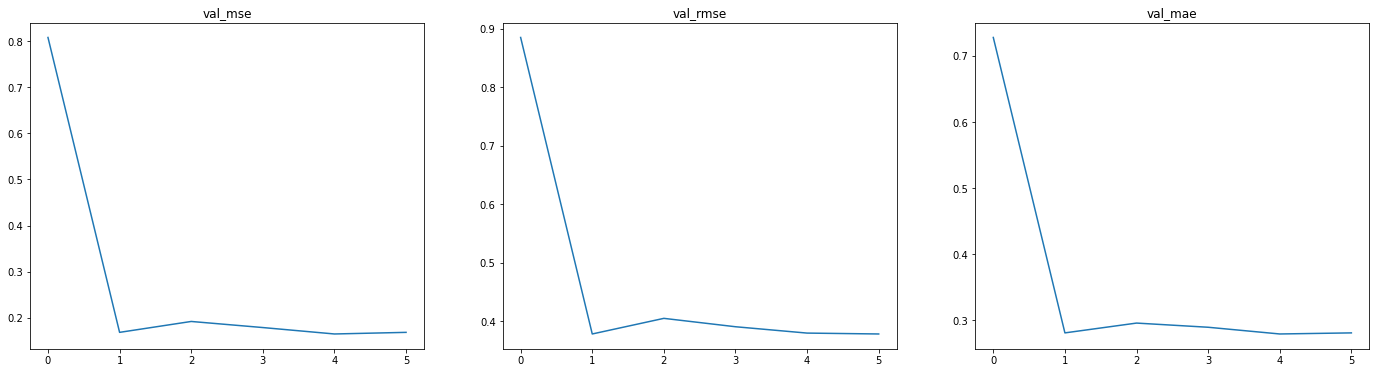

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.17112118005752563,
 'test_mse': 0.10154617577791214,
 'test_rmse': 0.2580389082431793}
--------------------------------------------------------------------------------
Prediction P-AD, beta=0.01, lambda=1
MSE: 0.10154617577791214, RMSE: 0.2580389082431793, MAE: 0.17112118005752563



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.30262959003448486,
 'test_mse': 0.1799381524324417,
 'test_rmse': 0.4151139259338379}
--------------------------------------------------------------------------------


[{'test_mae': 0.30262959003448486,
  'test_mse': 0.1799381524324417,
  'test_rmse': 0.4151139259338379}]

In [24]:
# P_AD
beta, lmbda = 0.01, 1
P_AD = LSTM(256, 128)
P_AD.set_pretrained_vae(model)

pad_trainer = pl.Trainer(
    gpus=gpus, 
    callbacks=[early_stop_callback], 
    check_val_every_n_epoch=check_val_every_n_epoch, 
    min_epochs=min_epochs, 
    max_epochs=max_epochs,
    auto_scale_batch_size='power',
    gradient_clip_val=0.8
)

pad_trainer.fit(P_AD, train_dataloader, val_dataloader)

plot_training(P_AD.trainer.logged_metrics, ['val_mse', 'val_rmse', 'val_mae'])

P_AD.clear()
pad_trainer.test(P_AD, test_dataloaders=test_dataloader)

mse = pad_trainer.logged_metrics['test_mse'].detach().item()
rmse = pad_trainer.logged_metrics['test_rmse'].detach().item()
mae = pad_trainer.logged_metrics['test_mae'].detach().item()
metrics_prediction.append([mse, rmse, mae])

print_predictor_metrics(mse, rmse, mae, beta, lmbda, 'P-AD')

P_AD.clear()
pad_trainer.test(P_AD, test_dataloaders=plot_dataloader)
#plot_model(model.vae, prediction=model.lstm.y_pred, ts_start=5500, ts_end=10000, title='PAD')

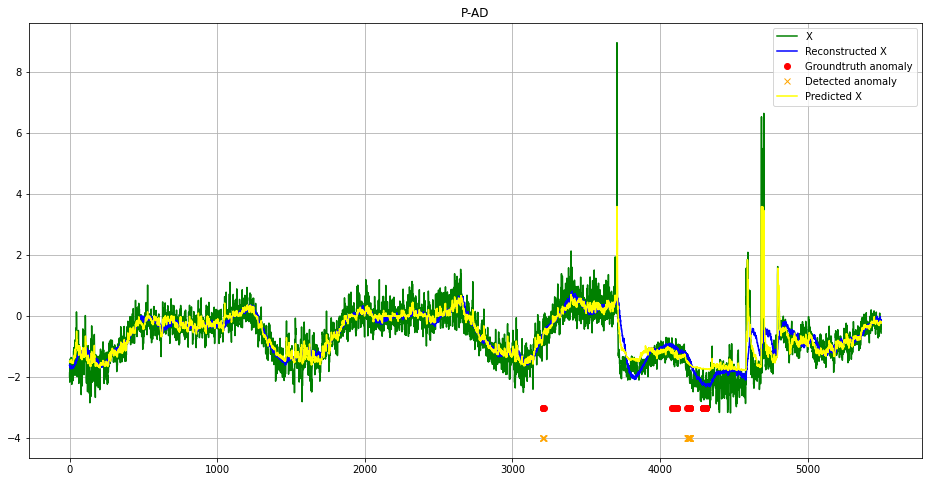

In [25]:
plot_model(model, prediction=P_AD.y_pred, ts_start=500, ts_end=6000, title='P-AD')

In [26]:
P_AD.vae = None
if not DEBUG:
    with open('/content/gdrive/My Drive/Colab Notebooks/hse-project-vae-lstm/P_AD.pcl', 'wb') as f:
        pickle.dump(P_AD, f)


In [34]:
pd.DataFrame(np.round(metrics_detection, decimals=3), columns=['F1', 'Precision', 'Recall'], index=['PAD beta=0.01', 'PAD beta=0.1', 'PAD beta=1', 'PAD beta=10', 'PAD- beta=0.01', 'AD beta=0.01'])

,F1,Precision,Recall
PAD beta=0.01,0.653,0.722,0.595
PAD beta=0.1,0.579,0.526,0.644
PAD beta=1,0.454,0.591,0.368
PAD beta=10,0.421,0.560,0.337
PAD- beta=0.01,0.581,0.514,0.669
AD beta=0.01,0.224,0.962,0.127


In [35]:
pd.DataFrame(np.round(metrics_prediction, decimals=3), columns=['MSE', 'RMSE', 'MAE'], index=['PAD beta=0.01', 'PAD beta=0.1', 'PAD beta=1', 'PAD beta=10', 'PAD- beta=0.01', 'P-AD beta=0.01'])

,MSE,RMSE,MAE
PAD beta=0.01,0.104,0.260,0.173
PAD beta=0.1,0.116,0.277,0.191
PAD beta=1,0.979,0.962,0.787
PAD beta=10,0.982,0.961,0.785
PAD- beta=0.01,0.162,0.318,0.197
P-AD beta=0.01,0.102,0.258,0.171
